In [1]:
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("thddbptnsndshs/nonce-lstm-sweeps")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

runs_df.head()

,summary,config,name
0,"{'odds': 2.8044351539053665, 'P>|z|': 3.371792...","{'lr': 0.001, 'num_layers': 10, 'config_path':...",helpful-sweep-10
1,"{'_timestamp': 1709629253.8705912, 'P>|z|': 3....","{'lr': 1e-05, 'num_layers': 10, 'config_path':...",distinctive-sweep-9
2,"{'val/loss': 2.938401699066162, 'train/loss': ...","{'lr': 1e-05, 'num_layers': 9, 'config_path': ...",helpful-sweep-8
3,"{'P>|z|': 1.3057684595233286e-31, '_step': 99,...","{'lr': 1e-05, 'num_layers': 10, 'config_path':...",radiant-sweep-7
4,"{'val/loss': 2.936650276184082, 'train/loss': ...","{'lr': 1e-05, 'num_layers': 10, 'config_path':...",kind-sweep-6


## summarizing the runs

In [2]:
runs_df = runs_df.merge(runs_df.config.apply(pd.Series), right_index=True, left_index=True)
runs_df = runs_df.merge(runs_df.summary.apply(pd.Series), right_index=True, left_index=True, suffixes=('', '_'))
runs_df['lang_code'] = runs_df.config_path.apply(lambda x: x.split('/')[-1].split('.')[0])
runs_df = runs_df.merge(pd.read_csv('../data/mapping.tsv', sep='\t', header=None), 
                        left_on='lang_code', right_on=0)
runs_df.drop(columns=['config', 'summary', '_step', '_wandb', '_timestamp', '_runtime'], inplace=True)
runs_df.rename(columns={1: 'syllable_complexity'}, inplace=True)

/tmp/ipykernel_82755/3350704906.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  runs_df = runs_df.merge(runs_df.summary.apply(pd.Series), right_index=True, left_index=True, suffixes=('', '_'))


In [3]:
runs_df = runs_df.dropna(subset='odds')

In [4]:
runs_df.head()

,name,lr,num_layers,config_path,hidden_size,embedding_dim,max_word_length,min_word_length,odds,P>|z|,val/loss,standard_error,train/loss,val/perplexity,lang_code,0,syllable_complexity
0,helpful-sweep-10,0.00100,10,configs/ar.yaml,512,64,14,1,2.804435,3.371792e-31,2.769568,11.617155,2.790617,15.952210,ar,ar,2
1,distinctive-sweep-9,0.00001,10,configs/ar.yaml,128,64,15,1,3.293309,3.323926e-37,3.467453,12.745000,3.476562,32.058456,ar,ar,2
2,helpful-sweep-8,0.00001,9,configs/ar.yaml,512,64,14,1,2.325923,4.413617e-24,2.938402,10.121987,2.938910,18.885887,ar,ar,2
3,radiant-sweep-7,0.00001,10,configs/ar.yaml,128,256,15,2,2.809629,1.305768e-31,3.501828,11.697945,3.509928,33.177967,ar,ar,2
4,kind-sweep-6,0.00001,10,configs/ar.yaml,512,256,15,1,2.685861,1.184034e-29,2.936650,11.309021,2.929586,18.855362,ar,ar,2


In [5]:
best_runs = runs_df.groupby('lang_code').min('odds')

In [12]:
!pip -q install seaborn
best_runs.head()

,lr,num_layers,hidden_size,embedding_dim,max_word_length,min_word_length,odds,P>|z|,val/loss,standard_error,train/loss,val/perplexity,syllable_complexity
lang_code,,,,,,,,,,,,,
ar,0.00001,2,128,64,10,1,2.325923,3.106160e-54,1.999034,10.121987,0.939346,7.386579,2
br,0.00010,2,128,64,7,1,2.136672,9.317086e-45,2.407965,9.384496,1.041928,11.111323,2
ca,0.00001,2,128,64,9,2,2.476595,1.028148e-54,2.207086,10.678752,0.968516,9.093610,1
cs,0.00001,4,128,64,7,1,2.992202,1.939649e-54,2.285863,12.050667,2.124311,9.837360,2
cv,0.00001,6,128,256,15,2,2.634988,4.507567e-52,3.209320,11.265507,3.202778,24.762238,2


In [13]:
out = best_runs[['lr', 'num_layers', 'hidden_size', 'embedding_dim', 'max_word_length',
       'min_word_length', 'odds', 'val/loss', 'val/perplexity', 'syllable_complexity']]

for col in [
    'odds',
    'val/loss',
    'val/perplexity',
]:
    out[col] = out[col].round(2)
    
print(out.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &       lr &  num\_layers &  hidden\_size &  embedding\_dim &  max\_word\_length &  min\_word\_length &  odds &  val/loss &  val/perplexity &  syllable\_complexity \\
lang\_code &          &             &              &                &                  &                  &       &           &                 &                      \\
\midrule
ar        &  0.00001 &           2 &          128 &             64 &               10 &                1 &  2.33 &      2.00 &            7.39 &                    2 \\
br        &  0.00010 &           2 &          128 &             64 &                7 &                1 &  2.14 &      2.41 &           11.11 &                    2 \\
ca        &  0.00001 &           2 &          128 &             64 &                9 &                2 &  2.48 &      2.21 &            9.09 &                    1 \\
cs        &  0.00001 &           4 &          128 &             64 &                7 &                1 &

/tmp/ipykernel_82755/1366096982.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out[col] = out[col].round(2)
/tmp/ipykernel_82755/1366096982.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(out.to_latex())


In [14]:
# !pip install -q seaborn

<Axes: >

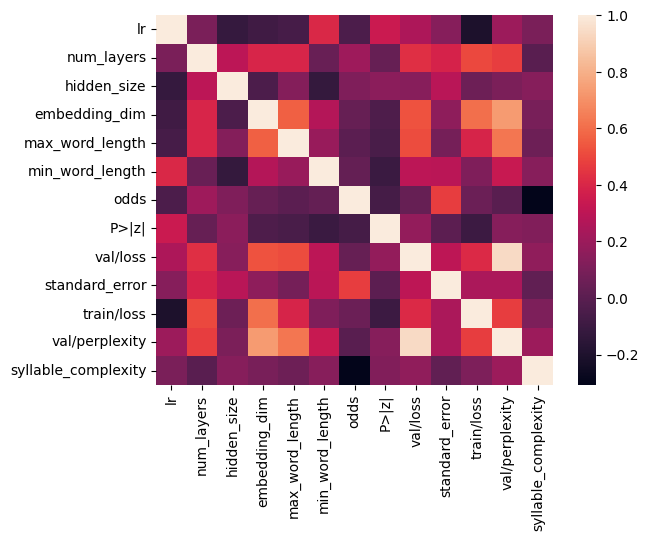

In [15]:
import seaborn as sns
%matplotlib inline

# calculate the correlation matrix on the numeric columns
corr = best_runs.select_dtypes('number').corr()

# plot the heatmap
sns.heatmap(corr)

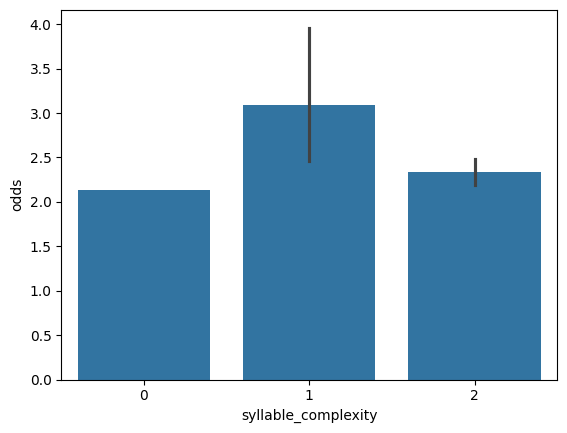

In [20]:
import matplotlib.pyplot as plt

sns.barplot(best_runs, x='syllable_complexity', y='odds')
plt.savefig('compl_plot.png')

In [17]:
!pip3 install -q scipy

In [18]:
from scipy.stats import ttest_ind

res = ttest_ind(
    best_runs.loc[(best_runs['syllable_complexity'] == 1), 'odds'],
    best_runs.loc[(best_runs['syllable_complexity'] == 2), 'odds'],
)
res


TtestResult(statistic=2.7836985643466976, pvalue=0.009212709918009652, df=30.0)

## make table with languages for appendix

In [65]:
# !wget -q https://github.com/haliaeetus/iso-639/raw/master/data/iso_639-2.json -P ../data/
# !wget -q https://github.com/NiuTrans/LanguageCodes/main/README.md -P ../data/

In [10]:
lang_map = pd.read_html('../data/README.md', encoding='utf-8', index_col=None, header=1
                       )[0].dropna().rename(columns={
                           'Language › Chinese Name': 'Language',
                           'Language Family› Branch': 'ISO-639-1',
                           'Writing System': 'ISO-639-2',
                           'Macro-area': 'ISO-639-3',
                           'Unnamed: 4': 'Language Family > Branch',
                           'Unnamed: 5': 'Writing System',
                           'Unnamed: 6': 'Macro-area',
}).drop(columns=['ISO-639-2', 'ISO-639-3', 'Writing System']).reset_index(drop=True)
lang_map = lang_map.loc[lang_map['ISO-639-1'].isin(best_runs.index)]
lang_map['Language'] = lang_map['Language'].apply(lambda x: x.split(' › ')[0])
lang_map['Language Family > Branch'] = lang_map['Language Family > Branch'].apply(lambda x: x.replace('›', '>'))
# lang_map['Writing System'] = lang_map['Writing System'].apply(lambda x: ', '.join(x.split()))
lang_map['Macro-area'] = lang_map['Macro-area'].apply(lambda x: ', '.join(x.split()))
lang_map['Syllable structure complexity'] = lang_map['ISO-639-1'].apply(lambda x: best_runs.loc[x, 'syllable_complexity'])
lang_map['Syllable structure complexity'] = lang_map['Syllable structure complexity'].map({
    0: 'Simple', 
    1: 'Moderately complex',
    2: 'Complex',
})
print(lang_map.sort_values('ISO-639-1').set_index('ISO-639-1').to_latex())

\begin{tabular}{lllll}
\toprule
{} &             Language &          Language Family > Branch &                                      Macro-area & Syllable structure complexity \\
ISO-639-1 &                      &                                   &                                                 &                               \\
\midrule
ar        &               Arabic &            Afro-Asiatic > Semitic &                                    Africa, Asia &                       Complex \\
br        &            Brezhoneg &            Indo-European > Celtic &                                          Europe &                       Complex \\
ca        &              Catalan &            Indo-European > Italic &                                          Europe &            Moderately complex \\
cs        &                Czech &      Indo-European > Balto-Slavic &                                          Europe &                       Complex \\
cv        &              Chuvash &        

/tmp/ipykernel_82755/1566779874.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(lang_map.sort_values('ISO-639-1').set_index('ISO-639-1').to_latex())


In [14]:
best_runs['syllable_complexity'].shape
best_runs.index.shape

(33,)

## preprocess data

In [5]:
import pandas as pd
eng = pd.read_csv('data/unigram_freq.csv')
eng = eng.loc[(eng.word != '') & (eng.word.apply(type) != float)]
eng['count'] = eng['count'].apply(lambda x: round(x / 50_000_000) if x / 500_000 > 1 else 1)
wordlist = []

for row in eng.iterrows():
#     print(row)
    wordlist.extend([row[1][0]] * row[1][1])

In [6]:
eng.head()

,word,count
0,the,463
1,of,263
2,and,260
3,to,243
4,a,182


In [7]:
len(wordlist)

303095

In [4]:
with open('data/vocab_txts/en_splits.txt', 'w') as f:
    f.write(' '.join(wordlist[40_000]))

In [26]:
rus = pd.read_csv('data/rus-ru_web-public_2019_30K-words.txt', delimiter='\t', header=None, quotechar="|").loc[37:]
rus[1] = rus[1].apply(lambda x: x.lower())
rus = rus.loc[rus[1].apply(lambda x: all([char in 'АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя'
                                   for char in x]))
       & (rus[1].apply(len) > 1)].drop_duplicates(subset=[0]).loc[:8000]

In [27]:
rus[2] = rus[2].apply(lambda x: round(x / 6) if x / 6 > 1 else 1)
wordlist = []

for row in rus.iterrows():
#     print(row)
    wordlist.extend([row[1][1]] * row[1][2])

In [28]:
len(wordlist)

39130

In [30]:
with open('data/vocab_txts/ru-freq_splits.txt', 'w') as f:
    f.write(' '.join(wordlist))

In [11]:
import random
import os

path = 'data/vocab_txts_short/'

for fn in os.listdir(path):
    with open(path + fn, 'r') as f:
        content = f.read().split()
    with open(path + fn, 'w') as f:
        f.write(' '.join(random.sample(content, min(4096, len(content)))))

In [16]:
with open('../data/vocab_txts/ar_splits.txt', 'r') as f:
    content = f.read().split()
with open('../data/vocab_txts_short/ar_splits.txt', 'w') as f:
    f.write(' '.join(random.sample(content, min(4096, len(content)))))

In [1]:
from model import CharModel, configure_model_and_optim
from dataset import configure_dataloaders
import torch
import yaml

In [2]:
import sys
sys.path.append('..')

In [267]:
import wandb
run = wandb.init()
artifact = run.use_artifact('thddbptnsndshs/nonce-lstm-sweeps/model:v1028', type='model')
artifact_dir = artifact.download()

wandb:   1 of 1 files downloaded.  


In [268]:
artifact_dir

'/home/jovyan/shikunova-as/nonce-words/src/artifacts/model:v1028'

In [273]:
config_path = '../select_configs/it.yaml'
with open(config_path) as cnf:
    config = yaml.safe_load(cnf)
    
config['data']['vocab_path'] = '../data/vocab_txts_short/it_splits.txt'

config['model']['embedding']['embedding_dim'] = 64
config['model']['gru']['input_size'] = 64 # need to update input_dim too, TODO: reduce to one parameter
config['model']['gru']['hidden_size'] = 128
config['model']['gru']['num_layers'] = 5
# config['data']['max_word_length'] = 15
# config['data']['min_word_length'] = 5

train_loader, test_loader, wordlist, charlist = configure_dataloaders(config)

id2char = dict(zip(range(len(charlist)), charlist))
char2id = dict(zip(charlist, range(len(charlist))))

model, optim, scheduler = configure_model_and_optim(charlist, config)

model = CharModel(charlist, config)
model.load_state_dict(torch.load(artifact_dir + '/unk.pt'))

<All keys matched successfully>

In [274]:
model.to('cuda')

CharModel(
  (embed): Embedding(39, 64)
  (lstm): GRU(64, 128, num_layers=5, batch_first=True)
  (linear): Linear(in_features=128, out_features=39, bias=True)
)

In [198]:
def verbose_generate(model, prefix='_', temperature=1.0, max_len=256, temp_decay=.8):
    x, y = [], []
    all_probs = []
    with torch.no_grad():
        while True:
#             print(temperature)
            token_probs = model.get_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                temperature *= temp_decay
                next_token = np.random.choice(tokens, p=probs)
                x.append(next_token)
                y.append(probs[tokens.index(next_token)])
                all_probs.append(probs)

            prefix += next_token
            if next_token == '^' or len(prefix) > max_len: break
    return prefix, x, y, all_probs


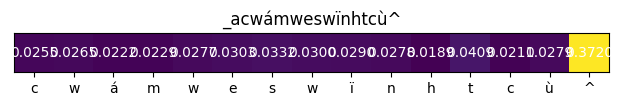

In [279]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl


word, x, y, all_probs = verbose_generate(model, '_a', temperature=2)
data = np.array(y).reshape(1, -1)

fig, ax = plt.subplots()
im = ax.imshow(data)

# Show all ticks and label them with the respective list entries
plt.xticks(np.arange(len(x)), labels=x)
plt.yticks([])

# Loop over data dimensions and create text annotations.
for y in range(data.shape[0]):
    for x in range(data.shape[1]):
        plt.text(x, y, '%.4f' % data[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 color='w'
                 )

ax.set_title(word)
fig.tight_layout()
plt.show()

In [280]:
print(word, end='\n\n')

for chosen_ch, dist in zip(word, list(all_probs)):
    print('top char', charlist[dist.argmax()])
#     print('chosen char position', np.argsort(dist)[charlist.index(chosen_ch)])
#     print('eos char position', np.argsort(dist)[charlist.index('^')])
    for char in np.argsort(dist)[-5:]:
        print(charlist[char], end=', ')
    print('\n')

_acwámweswïnhtcù^

top char ^
e, s, o, a, ^, 

top char ^
e, o, s, a, ^, 

top char ^
e, o, s, a, ^, 

top char ^
e, o, s, a, ^, 

top char ^
e, o, s, a, ^, 

top char ^
t, o, s, a, ^, 

top char ^
t, o, s, a, ^, 

top char ^
t, o, s, a, ^, 

top char ^
t, o, s, a, ^, 

top char ^
t, s, o, a, ^, 

top char ^
t, s, o, a, ^, 

top char ^
t, s, o, a, ^, 

top char ^
t, s, o, a, ^, 

top char ^
t, s, o, a, ^, 

top char ^
t, o, s, a, ^, 



In [254]:
def get_n_params(model):
    pp = 0
    for p in list(model.parameters()):
        nn = 1
        for s in list(p.size()):
            nn = nn * s
        pp += nn
    return pp

get_n_params(model)

263081

In [255]:
def generate(model, prefix='_', temperature=1.0, max_len=256, temp_decay=.8):
    with torch.no_grad():
        while True:
            token_probs = model.get_next_tokens(prefix)
#             print(temperature)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                temperature *= temp_decay # decrease temperature to encourage less eos tokens too soon
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == '^' or len(prefix) > max_len: break
    return prefix

In [256]:
print(word, end='\n\n')

for chosen_ch, dist in zip(word, list(all_probs)):
    print('top char', charlist[dist.argmax()])
    print('chosen char position', np.argsort(dist)[charlist.index(chosen_ch)])
    print('eos char position', np.argsort(dist)[charlist.index('^')])
    for char in np.argsort(dist)[-5:]:
        print(charlist[char], end=', ')
    print('\n')

_aөҗямсеч^

top char л
chosen char position 2
eos char position 0
р, т, е, а, л, 

top char л
chosen char position 3
eos char position 1
к, н, р, т, л, 

top char е
chosen char position 9
eos char position 1
т, и, л, ә, е, 

top char ^
chosen char position 7
eos char position 40
р, е, н, л, ^, 

top char ^
chosen char position 7
eos char position 6
л, н, ә, е, ^, 

top char е
chosen char position 28
eos char position 6
а, н, ә, ^, е, 

top char ^
chosen char position 4
eos char position 40
е, г, л, н, ^, 

top char ^
chosen char position 3
eos char position 6
л, н, ә, е, ^, 



In [259]:
generate(model, '_те', 3)

'_текбде^'

In [266]:
for _ in range(10): 
    print(generate(model, '_', 0.8, temp_decay=1.))

_ыла^
_утынп^
_тә^
_итмәге^
_зы^
_тгее^
_аына^
_өнлмә^
_әтгә^
_ала^


In [142]:
model.embed.weight.shape

torch.Size([34, 256])

In [143]:
from torch.nn.functional import cosine_similarity

def get_char_embedding(model, charlist, char):
    idx = charlist.index(char)
    return model.embed.weight[idx]

In [144]:
a_emb = get_char_embedding(model, charlist, 'a')
e_emb = get_char_embedding(model, charlist, 'r')

cosine_similarity(a_emb, e_emb, dim=0)

tensor(-0.1104, device='cuda:0', grad_fn=<SumBackward1>)

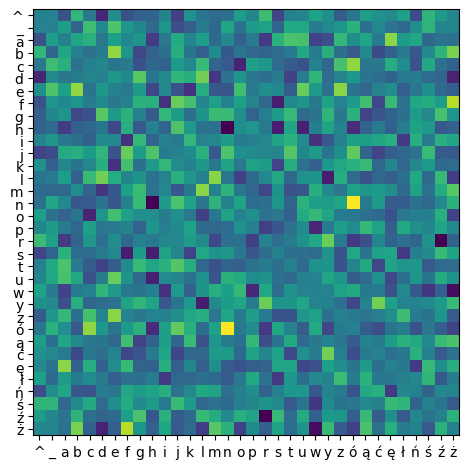

In [18]:
sim_matrix = np.zeros((len(charlist), len(charlist)))

for char1 in charlist:
    for char2 in charlist:
        sim = cosine_similarity(get_char_embedding(model, charlist, char1),
                                get_char_embedding(model, charlist, char2),
                                dim=0)
        if charlist.index(char1) != charlist.index(char2):
            sim_matrix[charlist.index(char1), charlist.index(char2)] = sim


fig, ax = plt.subplots()
im = ax.imshow(sim_matrix)

# Show all ticks and label them with the respective list entries
plt.xticks(np.arange(len(charlist)), labels=charlist)
plt.yticks(np.arange(len(charlist)), labels=charlist)

fig.tight_layout()
plt.show()

### estimating perplexity

In [82]:
from utils import *
import pandas as pd
# from model import *

def get_perplexity(model, stimuli):
    model.eval()
    df = pd.DataFrame({
        'Stimuli': stimuli,
    })
    val_history = []
    for word in stimuli:
        with torch.no_grad():
            word_t = torch.tensor(to_matrix([word], char2id)).to('cuda')
            logits = model(word_t[:, :-1]).permute(0, 2, 1)
            answers = word_t[:, 1:]
            mask = compute_mask(word_t, char2id)[:, 1:]
            l_v = loss(logits, answers, mask)
            perp = torch.exp(l_v)
            perp = perp.detach().cpu().numpy()
            val_history.append(perp.item())
    df['Perplexity scores'] = val_history
    df['Perplexity scores'] = df['Perplexity scores'].round(2)
    return df.set_index('Stimuli')

In [83]:
get_perplexity(model, ['kiki', 'bouba'])

,Perplexity scores
Stimuli,
kiki,15.99
bouba,20.56


In [178]:
initial_rt = [
    'rtugom',
    'ltamat',
    'rdeho',
    'lgaber',
    'rpipi',
]

initial_tr = [
    'trugom',
    'tlamat',
    'dreho',
    'glaber',
    'pripi',
]

In [179]:
print(get_perplexity(sl_model, initial_rt).to_latex())
print(get_perplexity(sl_model, initial_tr).to_latex())

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [153]:
print(get_perplexity(sl_model, initial_tr).to_latex())

\begin{tabular}{lr}
\toprule
{} &  Perplexity scores \\
Stimuli &                    \\
\midrule
trugom  &              11.29 \\
stlamat &              14.02 \\
dreho   &              28.96 \\
glaber  &              19.30 \\
pripi   &              20.30 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_64961/3476444253.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(get_perplexity(model, initial_tr).to_latex())


In [185]:
# this is Ukranian
initial_rt = [
    'ртугом',
    'лстамат',
    'рдехо',
    'лгабер',
    'рпiпи',
]

initial_tr = [
    'тругом',
    'стламат',
    'дрехо',
    'глабер',
    'прiпи',
]
print(get_perplexity(uk_model, initial_rt).to_latex())
print(get_perplexity(uk_model, initial_tr).to_latex())

\begin{tabular}{lr}
\toprule
{} &  Perplexity scores \\
Stimuli &                    \\
\midrule
ртугом  &              25.47 \\
лстамат &              18.64 \\
рдехо   &              23.91 \\
лгабер  &              36.30 \\
рпiпи   &              37.68 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
{} &  Perplexity scores \\
Stimuli &                    \\
\midrule
тругом  &              22.37 \\
стламат &              13.81 \\
дрехо   &              18.31 \\
глабер  &              25.16 \\
прiпи   &              24.90 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_64961/1697852235.py:17: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(get_perplexity(uk_model, initial_rt).to_latex())
/tmp/ipykernel_64961/1697852235.py:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(get_perplexity(uk_model, initial_tr).to_latex())


In [ ]:
assert False

In [161]:
# this is Slovene

model.to('cuda')
print(get_perplexity(model, initial_rt).to_latex())
print()
print(get_perplexity(model, initial_tr).to_latex())

\begin{tabular}{lr}
\toprule
{} &  Perplexity scores \\
Stimuli &                    \\
\midrule
rtugom  &              18.48 \\
lstamat &              14.92 \\
rdeho   &              15.88 \\
lgaber  &              14.51 \\
rpipi   &              21.25 \\
\bottomrule
\end{tabular}


\begin{tabular}{lr}
\toprule
{} &  Perplexity scores \\
Stimuli &                    \\
\midrule
trugom  &              10.21 \\
stlamat &              11.79 \\
dreho   &               9.17 \\
glaber  &              10.79 \\
pripi   &               7.59 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_64961/1815879618.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(get_perplexity(model, initial_rt).to_latex())
/tmp/ipykernel_64961/1815879618.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(get_perplexity(model, initial_tr).to_latex())


In [163]:
sl_model = model

In [175]:
uk_model = model

In [188]:
for _ in range(10):
    print(uk_model.generate())

_кк^
_хвк^
_аніюьотй^
_жоти^
_лк^
_лекнят^
_аббьнн^
_шлмиіія^
_iаоц^
_маа^


## zip the project

In [ ]:
import shutil

output_filename = 'nonce-words'
dir_name = '/home/jovyan/shikunova-as/nonce-words'
shutil.make_archive(output_filename, 'zip', dir_name)
